# Bonus Track Assignment#2:
## Implementing Liquid State Machines (LSMs)

In [216]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

### The "Liquid" is a layer of interconnected Izhikevich neurons
that takes in input our time series as an external applied current

In [217]:
def modified_lsm(input, Ne, Ni, win_e, win_i, w_e, w_i):

    re = np.random.rand(Ne)
    ri = np.random.rand(Ni)
    a = np.concatenate([0.02 * np.ones(Ne), 0.02 + 0.08 * ri])
    b = np.concatenate([0.2 * np.ones(Ne), 0.25 - 0.05 * ri])
    c = np.concatenate([-65 + 15 * re ** 2, -65 * np.ones(Ni)])
    d = np.concatenate([8 - 6 * re ** 2, 2 * np.ones(Ni)])

    U = np.concatenate([win_e * np.ones(Ne), win_i * np.ones(Ni)])
    S = np.concatenate([w_e * np.random.rand(Ne + Ni, Ne), -w_i * np.random.rand(Ne + Ni, Ni)], axis=1)

    v = -65 * np.ones(Ne + Ni)    # Initial values of v
    u = b * v                     # Initial values of u
    firings = []                  # spike timings

    states = []  # here we construct the matrix of reservoir states

    for t in range(input.shape[0]):  # simulation of 1000 ms

        I = input[t] * U
        fired = np.where(v >= 30)[0]    # indices of spikes
        firings.append(np.concatenate([t + np.zeros(len(fired)).reshape(-1, 1), fired.reshape(-1, 1)], axis=1))
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]

        I = I + np.sum(S[:, fired], axis=1)
        v = v + 0.5 * (0.04 * v ** 2 + 5 * v + 140 - u + I)    # step 0.5 ms
        v = v + 0.5 * (0.04 * v ** 2 + 5 * v + 140 - u + I)    # for numerical stability
        u = u + a * (b * v - u)

        states.append((v >= 30).astype(int))

    firings = np.concatenate(firings, axis=0)
    #plt.figure(figsize = (20,5))
    #plt.plot(firings[:, 0], firings[:, 1], '.')
    #plt.show()

    # in the end states is 1000 x number of time steps
    states = np.array(states).T
    return states

## Load the dataset

Text(0, 0.5, '# monthly sunspots')

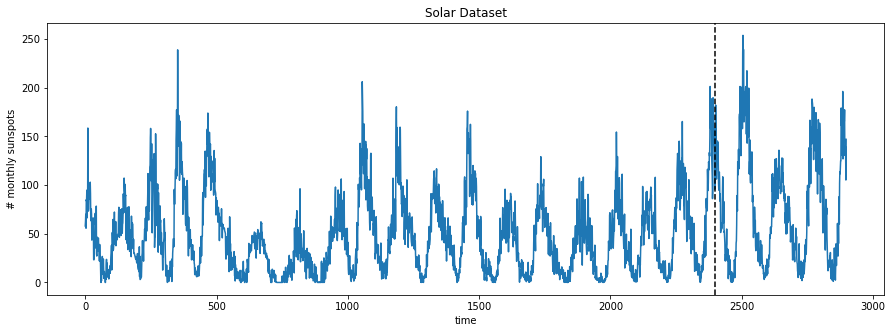

In [229]:
#import dataset
whole_dataset = np.loadtxt("solar_data.csv", delimiter=",")
x = whole_dataset[:-1] # input dataset
y = whole_dataset[1:] #target dataset

#split in train and test set
x_train = x[:2398]
y_train = y[:2398]
x_test = x[2398:]
y_test = y[2398:]

#plot the data
plt.figure(figsize = (15,5))
plt.title('Solar Dataset')
plt.plot(whole_dataset)
plt.axvline(x = 2398, color = 'black', linestyle= '--')
plt.xlabel('time')
plt.ylabel('# monthly sunspots')

for model selection, we further split the train data into train and validation 

In [219]:
X_train = x_train[:2000]
X_val = x_train[2000:]
Y_train = y_train[:2000]
Y_val = y_train[2000:]

print(len(x_train),len(X_val))

2398 398


Define the hyperparameter search space to do model selection:

In [226]:
#total number of neurons
N = [100,200] 
#percentage of excitatory neurons
perc = [0.5,0.8,0.9] 
# scaling of input connections
win_e=[1,2.5,5] 
win_i=[1,2.5,5] 
# scaling of recurrent connections
w_e=[0.1,0.25,0.5] 
w_i=[0.1,0.5,1] 

#compute all the possible combinations
p = np.array(np.meshgrid(N, perc, win_e,win_i,w_e,w_i)).T.reshape(-1,6)

print(f'The search space is composed of {len(p)} combinations of hyperparameters')

(486, 6)
The search space is composed of 486 combinations of hyperparameters


Find optimal parameters, i.e. the ones that minimize validation MAE

In [222]:
min_mae = 1e5 #very high value just to inizialize 
best = 0

for i in range(len(p)):
    Ne = int(p[i,0]*p[i,1])
    Ni = int(p[i,0] - Ne)
    win_e, win_i, w_e, w_i = p[i,2:]

    trainStates = modified_lsm(X_train, Ne, Ni, win_e, win_i, w_e, w_i)
    #readout weight matrix
    Wout = np.dot(Y_train,np.linalg.pinv(trainStates))
    valStates = modified_lsm(X_val, Ne, Ni, win_e, win_i, w_e, w_i)
    #Output of the LSM
    valOutput = np.dot(Wout, valStates)
    mae = mean_absolute_error(Y_val, valOutput)
    if mae < min_mae:
        min_mae = mae
        best = i
    print(f'iteration {i}, mae = {mae}, params: N={p[i,0]}, perc={p[i,1]}, win_e={p[i,2]}, win_i={p[i,3]}, w_e={p[i,4]}, w_i={p[i,5]}, best mae so far = {min_mae}')

best_params = p[best]
print(f'Finished model selection\nminimum mae = {min_mae} correspondig to \nbest params: N={best_params[0]}, perc={best_params[1]}, win_e={best_params[2]}, win_i={best_params[3]}, w_e={best_params[4]}, w_i={best_params[5]}')
np.save('lsm_params',best_params)

iteration 0, mae = 33.70167682018715, params: N=100.0, perc=0.5, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.70167682018715
iteration 1, mae = 39.96656055171402, params: N=100.0, perc=0.8, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.70167682018715
iteration 2, mae = 36.47788280990211, params: N=100.0, perc=0.9, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.70167682018715
iteration 3, mae = 56.9578473845026, params: N=200.0, perc=0.5, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.70167682018715
iteration 4, mae = 57.629409318336805, params: N=200.0, perc=0.8, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.70167682018715
iteration 5, mae = 80.6837282819083, params: N=200.0, perc=0.9, win_e=1.0, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.70167682018715
iteration 6, mae = 33.27192011967058, params: N=100.0, perc=0.5, win_e=2.5, win_i=1.0, w_e=0.1, w_i=0.1, best mae so far = 33.27192011967058
iteration 7, m

In [223]:
#best_params = np.load('lsm_params.npy')

### Solve the regression task using the optimal parameters found

In [224]:
Ne = int(best_params[0]*best_params[1])
Ni = int(best_params[0] - Ne)

trainStates = modified_lsm(X_train, Ne, Ni, *(best_params[2:]))

Wout = np.dot(Y_train,np.linalg.pinv(trainStates))
trainOutput = np.dot(Wout, trainStates)
mae_train = mean_absolute_error(Y_train, trainOutput)

valStates = modified_lsm(X_val,Ne, Ni, *(best_params[2:]))
valOutput = np.dot(Wout, valStates)
mae_val = mean_absolute_error(Y_val, valOutput)

testStates = modified_lsm(x_test,Ne, Ni, *(best_params[2:]))
testOutput = np.dot(Wout, testStates)
mae_test = mean_absolute_error(y_test, testOutput)

### Make plots

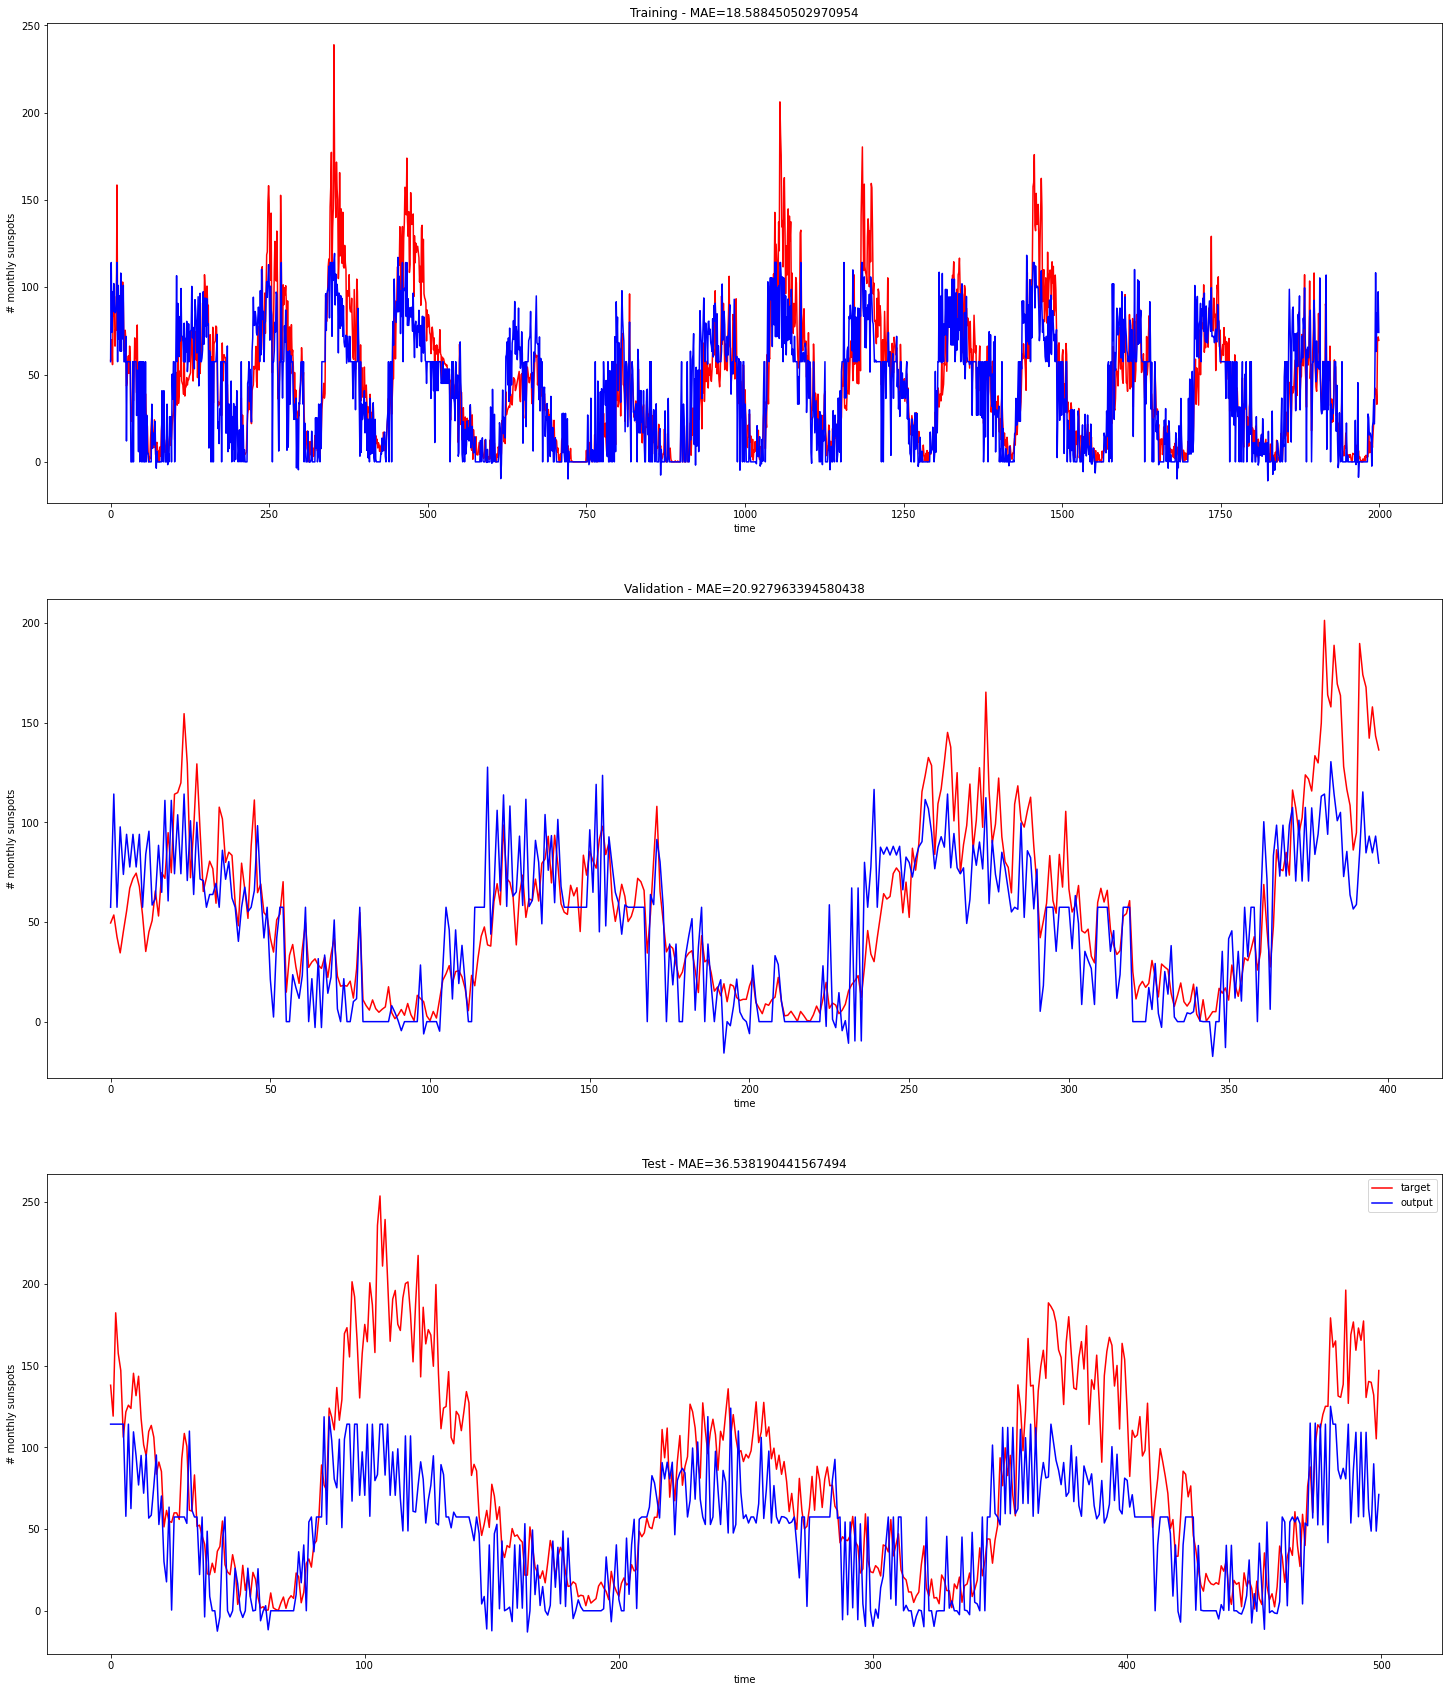

In [234]:
plt.figure(figsize = (25,30))
plt.subplot(311)
plt.title(f'Training - MAE={mae_train}')
plt.plot(X_train, color='red', label = 'target')
plt.plot(trainOutput, color = 'blue', label = 'output')
plt.xlabel('time')
plt.ylabel('# monthly sunspots')

plt.subplot(312)
plt.title(f'Validation - MAE={mae_val}')
plt.plot(X_val, color='red', label = 'target')
plt.plot(valOutput, color = 'blue', label = 'output')
plt.xlabel('time')
plt.ylabel('# monthly sunspots')

plt.subplot(313)
plt.title(f'Test - MAE={mae_test}')
plt.plot(y_test, color='red', label = 'target')
plt.plot(testOutput, color = 'blue', label = 'output')
plt.xlabel('time')
plt.ylabel('# monthly sunspots')
plt.legend()
plt.savefig(f"plots_bt2/Sunspot_target_vs_output.pdf")
plt.show()